# Project Title: Image Classification with EfficientDet

## Overview
In this notebook, we will explore image classification using the EfficientDet model. We will cover data loading, preprocessing, model training, and evaluation.

# 1. Setup and Installation
In this section, we will install necessary packages and set up the environment.

In [1]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.4 MB/s eta 0:00:00


In [2]:
import os
import sys
import pathlib

In [3]:
# Directory and file paths
repo_dir = 'content/Thesis'
dataset_url = 'https://github.com/quin-thifal/Thesis/raw/313cfed38782aa4beab080c762de87b38d92a8a8/dataset.zip'
dataset_zip = 'dataset.zip'
dataset_dir = 'dataset'

# Function to check if we are at the root directory
def at_root(path):
    return path == pathlib.Path('/')

# Navigate up the directory tree if necessary and check for the repo directory
current_path = pathlib.Path.cwd()
while not at_root(current_path):
    if (current_path / repo_dir).exists():
        os.chdir(current_path / repo_dir)
        sys.path.append('.')
        !git pull
        break
    current_path = current_path.parent
else:
    os.chdir(current_path)
    !git clone --branch master --single-branch https://github.com/quin-thifal/Thesis.git {repo_dir}
    os.chdir(repo_dir)
    sys.path.append('.')

# Define the full path to the dataset directory
full_dataset_dir = pathlib.Path(repo_dir) / dataset_dir

# Check if the dataset needs to be downloaded and unzipped
if not full_dataset_dir.exists():
    !wget {dataset_url}
    !unzip -o -d {dataset_dir}/ {dataset_zip}
    os.remove(dataset_zip)

Cloning into 'content/Thesis'...
remote: Enumerating objects: 519, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 519 (delta 105), reused 229 (delta 97), pack-reused 278 (from 1)
Receiving objects: 100% (519/519), 958.95 MiB | 28.85 MiB/s, done.
Resolving deltas: 100% (211/211), done.
--2024-08-31 07:32:26--  https://github.com/quin-thifal/Thesis/raw/313cfed38782aa4beab080c762de87b38d92a8a8/dataset.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/quin-thifal/Thesis/313cfed38782aa4beab080c762de87b38d92a8a8/dataset.zip [following]
--2024-08-31 07:32:26--  https://raw.githubusercontent.com/quin-thifal/Thesis/313cfed38782aa4beab080c762de87b38d92a8a8/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.1

In [4]:
# Prepare project file
!cat project/foot-ulcer.yml

project_name: foot-ulcer
train_set: train
val_set: val
num_gpus: 1

mean: [0.24406503, 0.24056134, 0.1945087]
std: [0.25623637, 0.25718808, 0.21674845]

anchors_scales: '[1, 1.25, 1.5]'
anchors_ratios: '[(1.0, 1.0), (1.0, 1.0), (2.0, 0.5)]'

obj_list: ['Healthy', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

In [5]:
import cv2
import json
import torch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from torch.backends import cudnn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

# 2. Data Loading and Preprocessing
Here we will load and preprocess the data. This includes data augmentation, resizing, and splitting into training and validation sets.

In [6]:
# Load the CSV file into a DataFrame
csv_file_path = '/content/Thesis/dataset/foot-ulcer/dataset.csv'  # Update this to your file path
df = pd.read_csv(csv_file_path)
display(df)

# Define the order of categories for the x-axis
order = ['Healthy', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# Define colors based on diagnosis categories
colors = {
    'Healthy': '#00FF00',
    'Class 1': '#FFFF00',
    'Class 2': '#FFCC00',
    'Class 3': '#FF9900',
    'Class 4': '#FF6600',
    'Class 5': '#FF0000'
}

,FILE,DIAGNOSIS,SUBJECT,GENDER,AGE,WEIGHT,HEIGHT,IMC,RG,RLCA,...,RMCA,RMPA,RTCI,LG,LLCA,LLPA,LMCA,LMPA,LTCI,TCI
0,CG004_F,Healthy,CG004,F,22,65.0,1.55,27.055151,27.878923,27.677861,...,28.515149,27.565520,1.818168,27.660045,27.549917,27.339314,28.266224,26.839619,1.498769,1.658468
1,CG005_F,Healthy,CG005,F,38,60.0,1.58,24.034610,26.215785,26.347802,...,26.795321,26.251804,0.287098,26.749582,26.804140,26.158323,27.393622,26.886416,0.810625,0.548862
2,CG006_F,Healthy,CG006,F,52,69.0,1.59,27.293224,26.530820,27.324513,...,27.760419,26.266871,0.784204,26.881679,27.530866,26.110816,27.917089,26.566670,1.031360,0.907782
3,CG009_M,Healthy,CG009,M,30,70.0,1.67,25.099502,24.714733,23.784455,...,24.865430,25.512076,1.380600,24.966484,24.207868,24.535479,24.957262,25.709660,1.147433,1.264016
4,CG010_M,Healthy,CG010,M,26,63.0,1.85,18.407597,26.984007,27.293590,...,28.140643,26.852704,1.165262,26.803791,26.739731,26.415619,27.509865,26.671372,0.834147,0.999705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,DM098_M,Class 3,DM098,M,74,65.0,1.60,25.390625,30.142835,29.285096,...,28.978813,31.146611,4.025029,28.780987,28.438373,28.798585,28.491248,29.246871,2.743769,3.384399
86,DM099_F,Class 2,DM099,F,56,100.8,1.61,38.887389,28.850141,29.512141,...,29.517806,28.521703,2.980034,27.004412,27.643666,26.125590,28.256254,26.661862,1.171843,2.075939
87,DM102_F,Class 2,DM102,F,70,54.5,1.54,22.980266,28.104542,28.067665,...,28.071594,28.536322,2.163039,28.516915,28.424661,28.458795,28.418474,29.556978,2.714727,2.438883
88,DM104_F,Class 3,DM104,F,47,109.0,1.54,45.960533,28.343768,28.101755,...,28.921898,28.657663,2.411881,29.746684,28.829307,29.772924,30.014554,30.291597,3.727095,3.069488


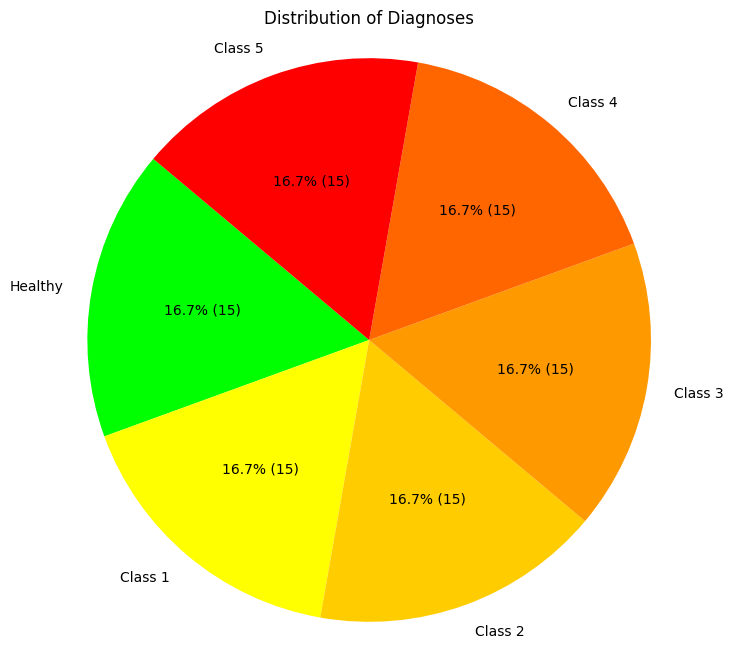

In [7]:
# Count the occurrences of each unique value in the 'DIAGNOSIS' column
diagnosis_counts = df['DIAGNOSIS'].value_counts()

# Reorder diagnosis_counts based on the defined order
diagnosis_counts = diagnosis_counts.reindex(order)

# Define a function to format labels with both count and percentage
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f'{pct:.1f}% ({absolute})'

# Use the colors in the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    diagnosis_counts,
    labels=diagnosis_counts.index,
    colors=[colors.get(label, '#D3D3D3') for label in diagnosis_counts.index],  # Default to light gray for unknown labels
    autopct=lambda pct: func(pct, diagnosis_counts),
    startangle=140
)
plt.title('Distribution of Diagnoses')
plt.axis('equal')

# Display the pie chart
plt.show()

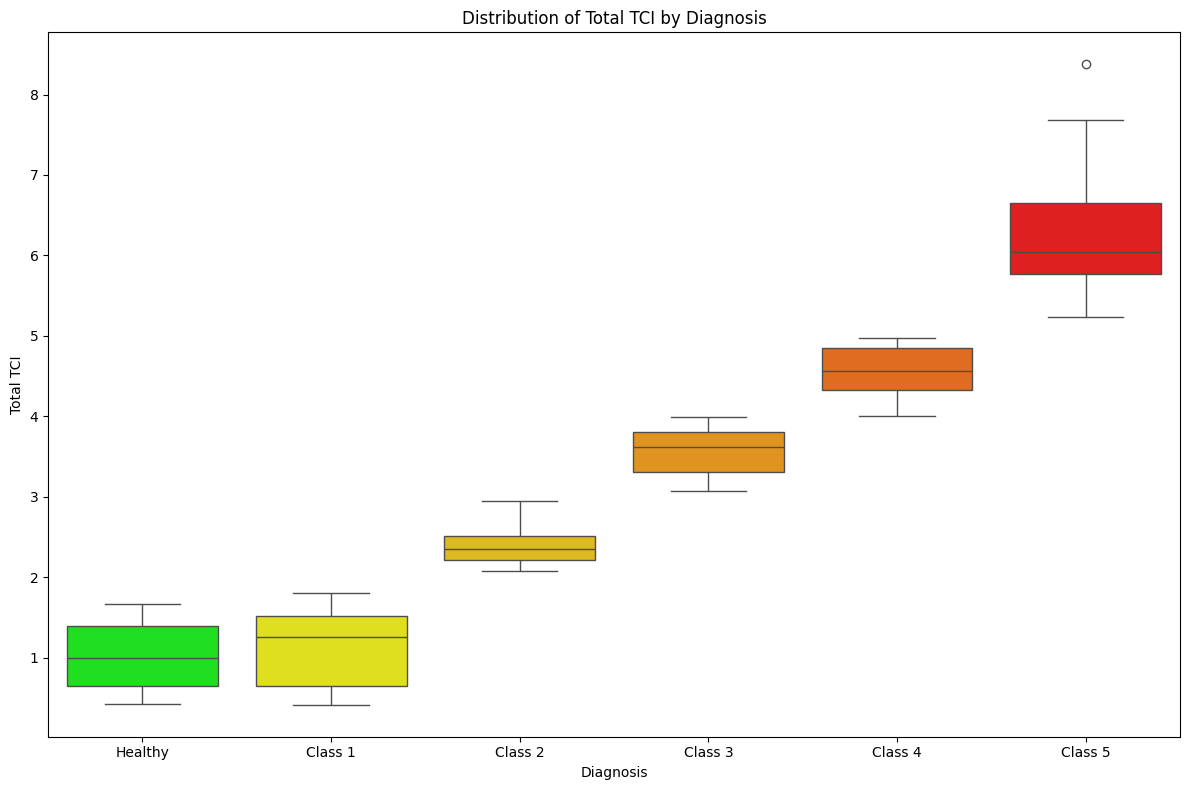

In [8]:
# Suppress specific FutureWarnings
warnings.filterwarnings("ignore")

# Create a box plot to show the distribution of TCI values for each diagnosis
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='DIAGNOSIS', y='TCI', palette=colors, order=order)

# Set labels and title
plt.xlabel('Diagnosis')
plt.ylabel('Total TCI')
plt.title('Distribution of Total TCI by Diagnosis')

# Display the plot
plt.tight_layout()
plt.show()

# 3. Model Definition
Define the architecture of the EfficientDet model or any other model you are using.

# 4. Training
Train the model with the preprocessed data and save the model checkpoints.

## Without Weights

In [9]:
#!python train.py -c 0 -p foot-ulcer -n 6 --batch_size 8 --lr 1e-2 --num_epochs 300

## With Weights

In [10]:
!python train.py -c 0 -p foot-ulcer -n 6 --lr 1e-2 --load_weights weights/6A.pth --batch_size 6 --num_epochs 100

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/content/Thesis/train.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models fo

# 5. Evaluation
Evaluate the model performance on validation/test data and visualize results.

In [11]:
# Change directory to where the weight files are located
weight_dir = '/content/Thesis/logs/foot-ulcer'

# Get the most recently modified weight file
files_in_dir = [f for f in os.listdir(weight_dir) if f.endswith('.pth')]
weight_file = max(files_in_dir, key=lambda f: os.path.getmtime(os.path.join(weight_dir, f)))

# Print the latest weight file for verification
print(f"Latest weight file: {weight_file}")

# Download the weight file to local/laptop
file_path = os.path.join(weight_dir, weight_file)
files.download(file_path)

# Use the latest weight file in the evaluation script
!python coco_eval.py -c 0 -p foot-ulcer -w "logs/foot-ulcer/{weight_file}"

Latest weight file: efficientdet-d0_99_1100.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

running coco-style evaluation on project foot-ulcer, weights logs/foot-ulcer/efficientdet-d0_99_1100.pth...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/content/Thesis/coco_eval.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the l

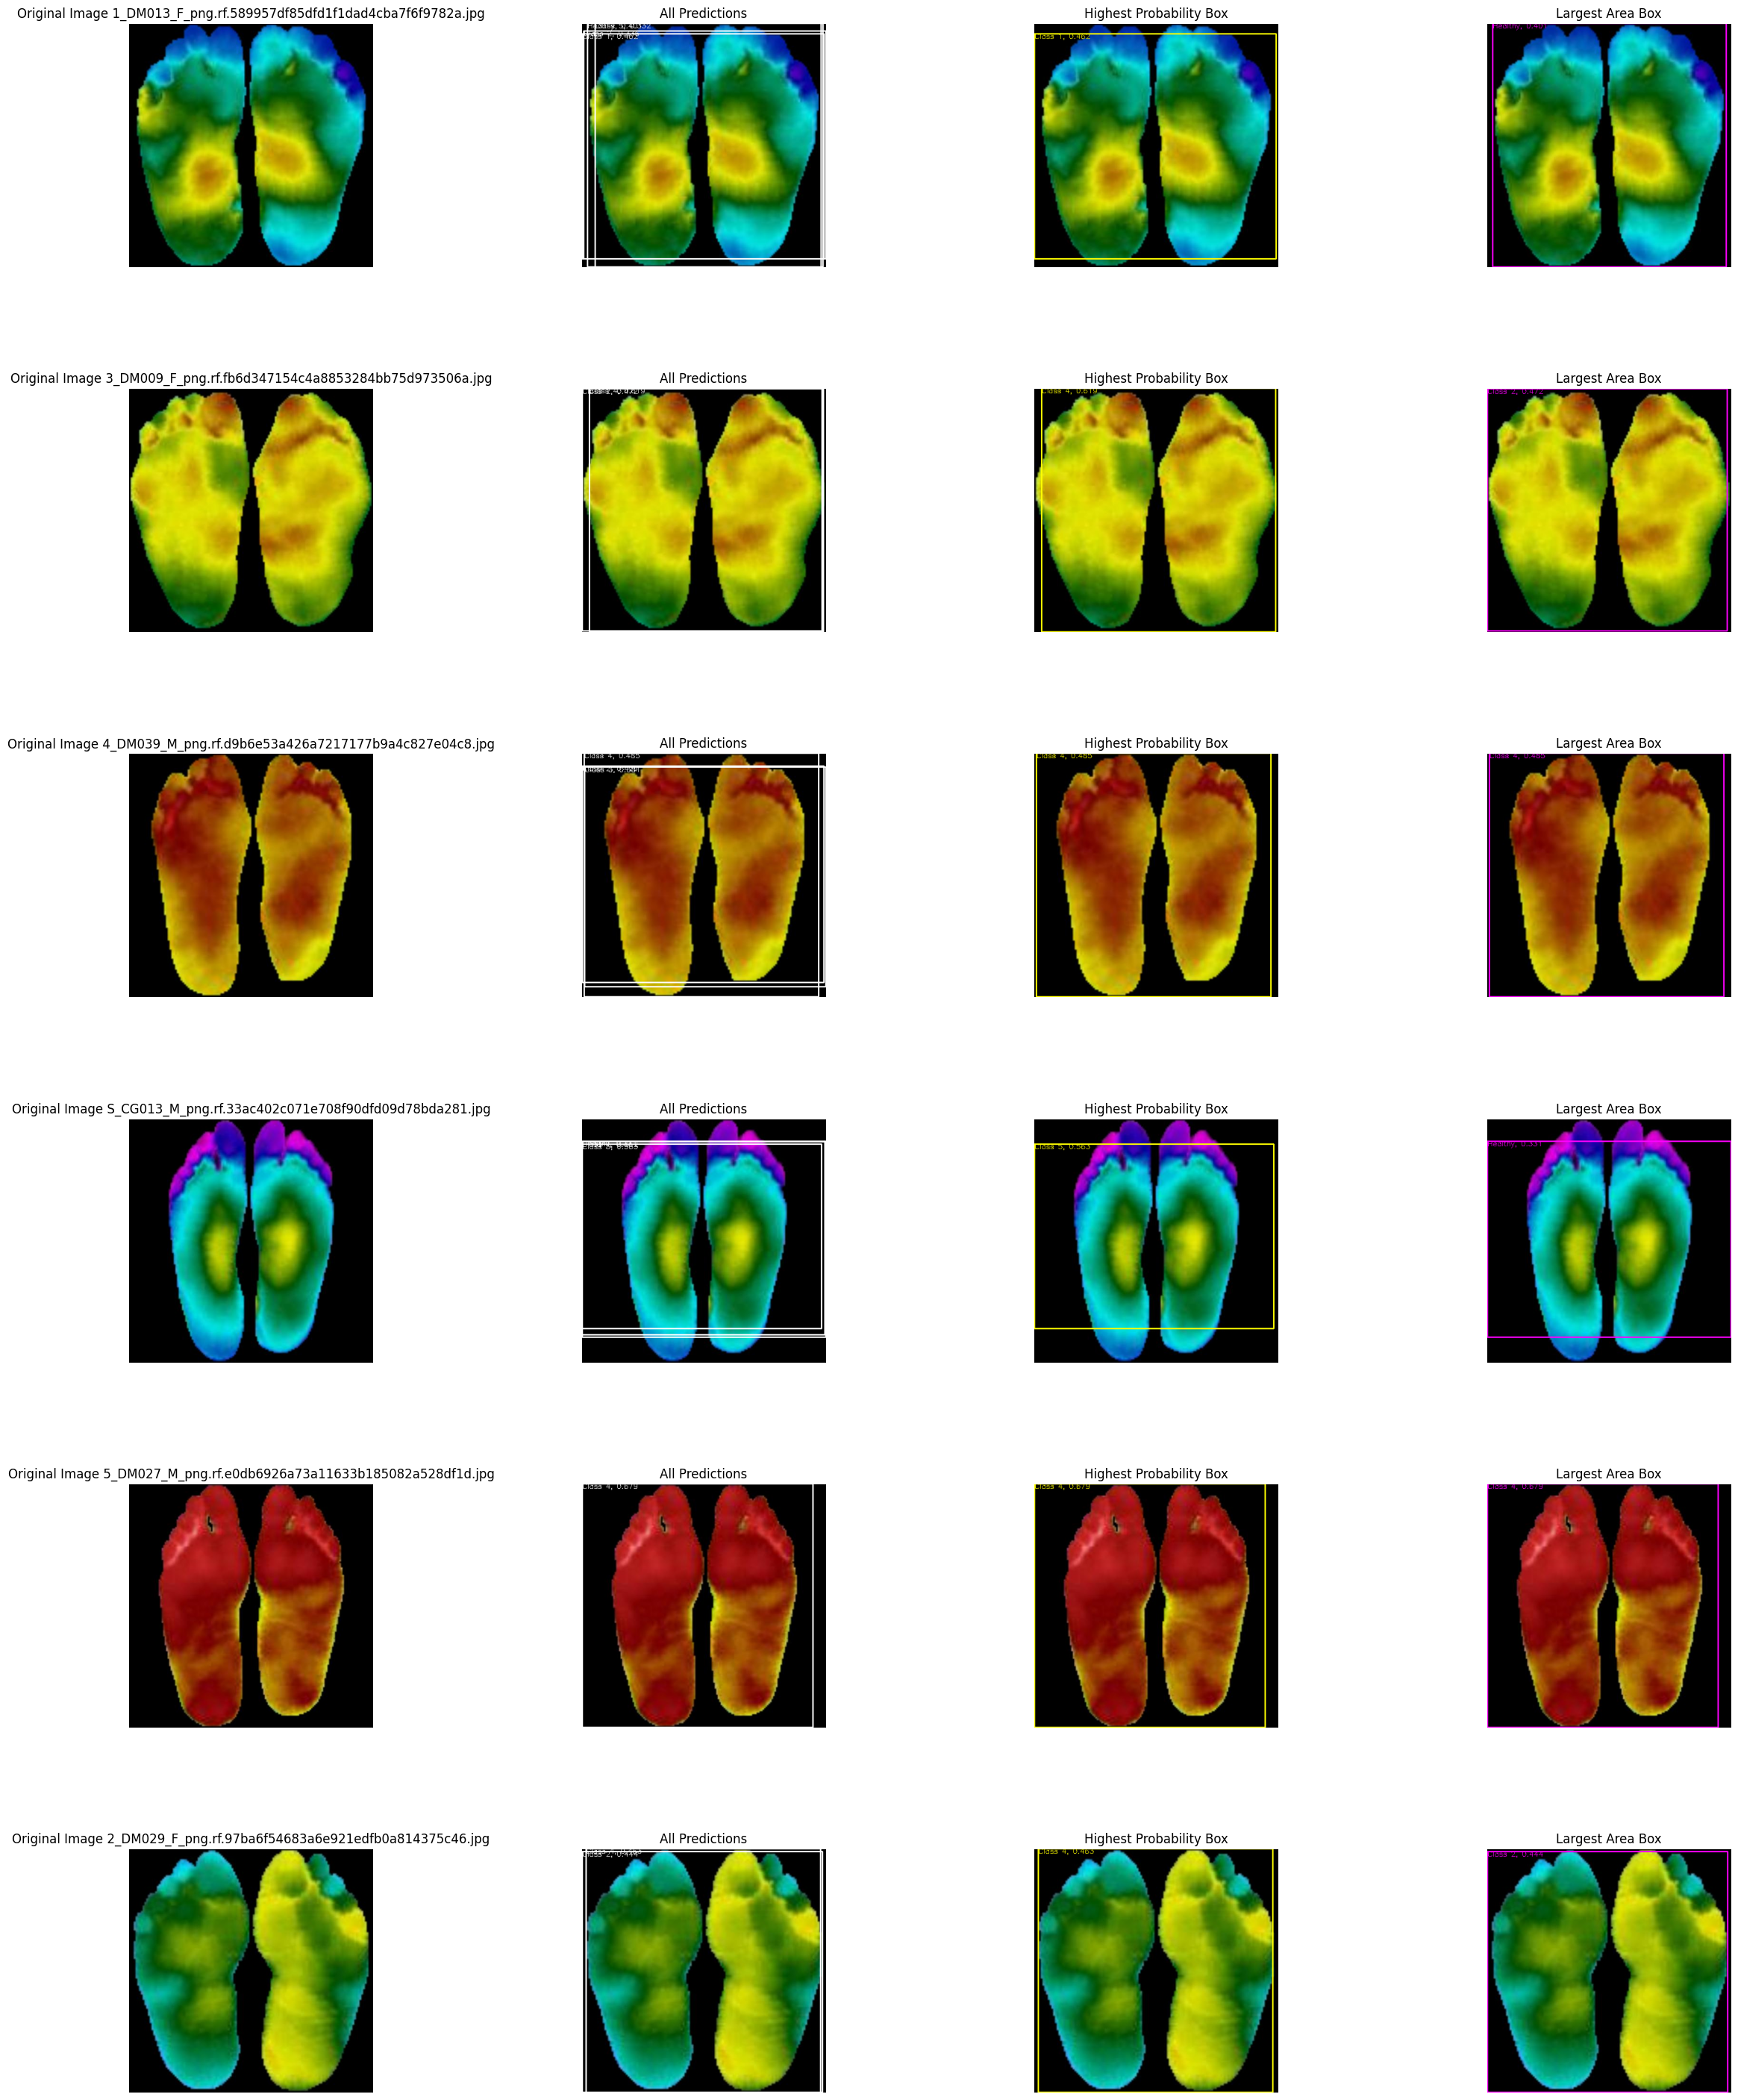

In [12]:
# Configuration
compound_coef = 0
force_input_size = None
img_dir = '/content/Thesis/dataset/foot-ulcer/test'
threshold = 0.2
iou_threshold = 0.2
use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['Healthy', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size

# Initialize the model
model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             ratios=[(1.0, 1.0), (1.0, 1.0), (2.0, 0.5)],
                             scales=[1, 1.25, 1.5])

# Load weights
model.load_state_dict(torch.load('logs/foot-ulcer/' + weight_file))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

# Get all images from the directory
img_names = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

# Initialize lists for results
data_for_df = []

# Create a figure to hold all images
fig, axs = plt.subplots(len(img_names), 4, figsize=(30, len(img_names) * 6))  # Adjusted number of columns
plt.subplots_adjust(hspace=0.5)

for idx, img_name in enumerate(img_names):
    img_path = os.path.join(img_dir, img_name)
    ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    with torch.no_grad():
        features, regression, classification, anchors = model(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)

    out = invert_affine(framed_metas, out)

    if len(out[0]['rois']) == 0:
        # Add a default prediction box if none are detected
        out[0]['rois'] = np.array([[0, 0, input_size, input_size]])
        out[0]['class_ids'] = np.array([0])
        out[0]['scores'] = np.array([1.0])

    scores = out[0]['scores']
    rois = out[0]['rois']
    class_ids = out[0]['class_ids']

    # Calculate the image center
    img_center = (input_size / 2, input_size / 2)

    # Calculate areas of bounding boxes
    areas = [(x2 - x1) * (y2 - y1) for (x1, y1, x2, y2) in rois]

    if len(scores) > 0:
        # Store predictions
        predictions = list(zip(rois, class_ids, scores, areas))

        # Find the highest probability
        highest_prob_index = np.argmax(scores)
        highest_prob = scores[highest_prob_index]

        # Find the bounding box with the closest delta to the center
        if np.any(scores == highest_prob):
            high_prob_boxes = [pred for pred in predictions if pred[2] == highest_prob]
            centers = [( (x1 + x2) / 2, (y1 + y2) / 2 ) for (x1, y1, x2, y2), _, _, _ in high_prob_boxes]
            distances = [np.sqrt((center[0] - img_center[0])**2 + (center[1] - img_center[1])**2) for center in centers]
            closest_to_center_index = np.argmin(distances)
            best_box_index = [i for i, (box, _, _, _) in enumerate(high_prob_boxes)][closest_to_center_index]
        else:
            best_box_index = random.choice(range(len(predictions)))

        # Find the bounding box with the largest area
        if len(areas) > 0:
            largest_area_index = np.argmax(areas)
        else:
            largest_area_index = random.choice(range(len(predictions)))

        # Store data for DataFrame only for labels
        data_for_df.append({
            'Image': img_name,
            'Highest Probability Label': obj_list[class_ids[best_box_index]] if len(scores) > 0 else 'N/A',
            'Largest Area Label': obj_list[class_ids[largest_area_index]] if len(areas) > 0 else 'N/A'
        })

        # Draw all boxes on the original image
        img_with_all_boxes = ori_imgs[0].copy()
        for j in range(len(rois)):
            (x1, y1, x2, y2) = rois[j].astype(int)
            color = (255, 255, 255)  # Default color (white) for all boxes

            cv2.rectangle(img_with_all_boxes, (x1, y1), (x2, y2), color, 2)
            obj = obj_list[class_ids[j]]
            score = float(scores[j])
            cv2.putText(img_with_all_boxes, '{}, {:.3f}'.format(obj, score),
                        (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        color, 1)

        # Display results
        axs[idx, 0].imshow(cv2.cvtColor(ori_imgs[0], cv2.COLOR_BGR2RGB))
        axs[idx, 0].set_title(f'Original Image {img_name}')
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(cv2.cvtColor(img_with_all_boxes, cv2.COLOR_BGR2RGB))
        axs[idx, 1].set_title('All Predictions')
        axs[idx, 1].axis('off')

        # Highest Probability Box
        img_with_boxes = ori_imgs[0].copy()
        if len(scores) > 0:
            (x1, y1, x2, y2) = rois[best_box_index].astype(int)
            color = (0, 255, 255)  # Cyan
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
            obj = obj_list[class_ids[best_box_index]]
            score = float(scores[best_box_index])
            cv2.putText(img_with_boxes, '{}, {:.3f}'.format(obj, score),
                        (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        color, 1)
        axs[idx, 2].imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        axs[idx, 2].set_title('Highest Probability Box')
        axs[idx, 2].axis('off')

        # Largest Area Box
        img_with_boxes = ori_imgs[0].copy()
        if len(areas) > 0:
            (x1, y1, x2, y2) = rois[largest_area_index].astype(int)
            color = (255, 0, 255)  # Magenta
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
            obj = obj_list[class_ids[largest_area_index]]
            score = float(scores[largest_area_index])
            cv2.putText(img_with_boxes, '{}, {:.3f}'.format(obj, score),
                        (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        color, 1)
        axs[idx, 3].imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        axs[idx, 3].set_title('Largest Area Box')
        axs[idx, 3].axis('off')

plt.show()

# 6. Results and Analysis
Analyze the results, visualize the predictions, and discuss the findings.

In [13]:
# Display DataFrame (to be saved or printed as needed)
df = pd.DataFrame(data_for_df)

# Determine real labels for the six classes
df['Real Label'] = df['Image'].apply(
    lambda x: 'Healthy' if x.startswith('S') else
              'Class 1' if x.startswith('1') else
              'Class 2' if x.startswith('2') else
              'Class 3' if x.startswith('3') else
              'Class 4' if x.startswith('4') else
              'Class 5' if x.startswith('5') else 'Unknown'
)

display(df)

,Image,Highest Probability Label,Largest Area Label,Real Label
0,1_DM013_F_png.rf.589957df85dfd1f1dad4cba7f6f97...,Class 1,Healthy,Class 1
1,3_DM009_F_png.rf.fb6d347154c4a8853284bb75d9735...,Class 4,Class 2,Class 3
2,4_DM039_M_png.rf.d9b6e53a426a7217177b9a4c827e0...,Class 4,Class 4,Class 4
3,S_CG013_M_png.rf.33ac402c071e708f90dfd09d78bda...,Class 5,Healthy,Healthy
4,5_DM027_M_png.rf.e0db6926a73a11633b185082a528d...,Class 4,Class 4,Class 5
5,2_DM029_F_png.rf.97ba6f54683a6e921edfb0a814375...,Class 4,Class 2,Class 2


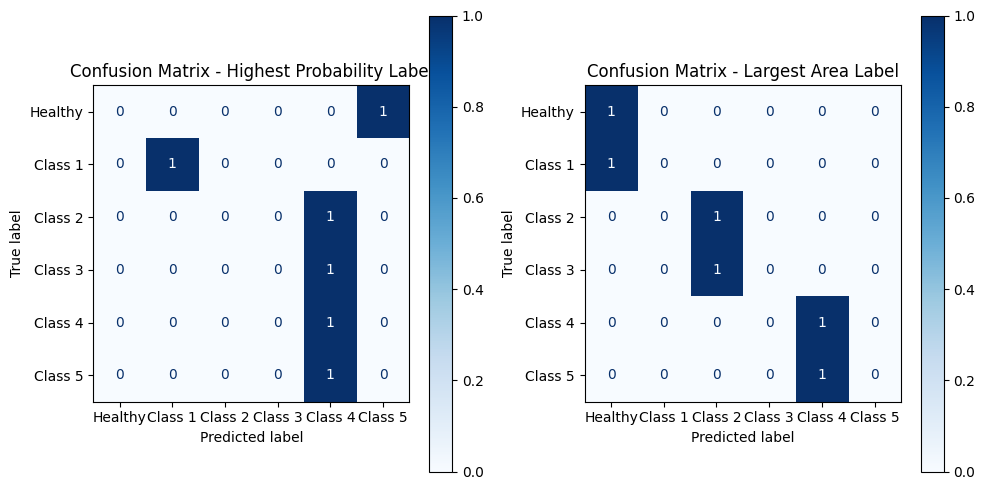

In [14]:
# Extract labels for each method
labels = ['Highest Probability Label', 'Largest Area Label']

# Initialize a dictionary to hold confusion matrices
cm_dict = {}

# Create confusion matrices for each method
for label in labels:
    cm = confusion_matrix(df['Real Label'], df[label], labels=['Healthy', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
    cm_dict[label] = cm

# Plot confusion matrices
fig, axs = plt.subplots(1, len(labels), figsize=(10, 5))  # Adjusted figure size for six plots

for ax, (label, cm) in zip(axs, cm_dict.items()):
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
    cmd.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    ax.set_title(f'Confusion Matrix - {label}')

plt.tight_layout()
plt.show()

# 7. Conclusion
Summarize the findings, discuss potential improvements, and outline future work.